# Quantum Perceptron Demo in Q\# #

This notebook uses the Python ineroperability for the [Quantum Development Kit](https://github.com/Microsoft/Quantum) to demonstrate a sample implementation for what a perceptron model run on a quantum computer would look like. The original code is based of the [MLADS2018-QuantumML]( https://github.com/Microsoft/MLADS2018-QuantumML) repo.

The classification task for this sample is a clustering of angles split "seperation" angle and gap spacing specified by the user. 

---

## Getting started

First we will load the packages we need, including the Q# interoperability package `qsharp`.

In [12]:
import numpy as np
import random
import matplotlib.pyplot as plt

import qsharp
qsharp.component_versions()

{'iqsharp': LooseVersion ('0.5.1904.1302'),
 'Jupyter Core': LooseVersion ('1.1.13141.0'),
 'qsharp': LooseVersion ('0.5.1903.2902')}

We have our file with the Q# operations also in this directory (`quantum-perceptron.qs`), so let's make sure they compile correctly by asking the IQsharp kernel to reload.

In [13]:
qsharp.reload()

Now, let's check that we have successfully loaded our Q# operations into our notebook's namespace:

In [14]:
qsharp.get_available_operations_by_namespace()

{'QuantumPerceptron': ['Classify',
  'EncodeDataInQubits',
  'EstimateQuantumClassifierSuccessRate',
  'Validate']}

---
## Generating the dataset

Now that we have our notebook setup, let's generate the test data!  We will choose a `seperation_angle` and an anglular `seperation_gap` (centered on the seperation angle) seperating the two sets of angles. 

**N.B.** All the angles are in radian!

In [15]:
def generate_dataset(n_data_points, separation_angle, separation_gap):
    labels = np.random.randint(0, 2, size=(n_data_points,))
    thetas = separation_angle + separation_gap / 2 + np.pi * labels                        \
                + (np.pi - separation_gap) * np.random.uniform(0, 1, size=(n_data_points, ))
    return labels, thetas % (2 * np.pi)

In [16]:
def plot_dataset(separation_angle, labels, thetas):
    ax = plt.subplot(111, projection='polar')
    for label in range(2):
        ax.scatter(thetas[labels == label], np.ones_like(thetas[labels == label]), color="rb"[label])

    ax.set_rmax(2)
    ax.set_rticks([0.5, 1, 1.5])  # less radial ticks
    ax.set_rlabel_position(-22.5)  # get radial labels away from plotted line
    ax.grid(True)
    ax.set_title("Split angle data set for classification", va='bottom')
    ax.vlines(separation_angle, 0, 2.1, 'k', ':')
    ax.vlines(separation_angle + np.pi, 0, 2.1, 'k', ':')
    plt.show()

1.8849555921538759


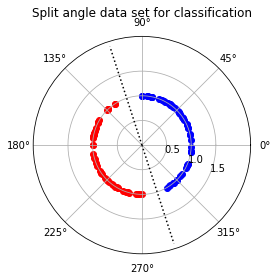

In [38]:
angle = 3 * np.pi / 5
print(angle)
labels, thetas = generate_dataset(101, angle, np.pi / 8)
plot_dataset(angle, labels, thetas)

---
## Testing the Quantum Perceptron

Now we have our dataset, and loaded our Q# operations from `quantum-perceptron.qs`, let's see how well it works!

We will start by loading the operation we need to estimate how well our quantum implementation of a perceptron classified a particular dataset. 

In [19]:
from QuantumPerceptron import EstimateQuantumClassifierSuccessRate

**N.B.** The `alpha` argument to `EstimateQuantumClassifierSuccessRate` is our current guess at what the seperation angle might be for the dataset.

In [20]:
EstimateQuantumClassifierSuccessRate.simulate(alpha=np.pi/2, dataPoints=thetas.tolist(), labels=labels.tolist(), nIterations=200)

Estimating classifier success rate at 1.5707963267949...


0.85

Now to improve our classification, we need to have a way to modify and keep track of our guesses for `alpha` or the dataset seperation angle. Here we'll do a ternary search, but there are definantly faster ways you could pick to do this. Take your best shot!

In [21]:
def get_ternary_boundries(lower_estimate, upper_estimate):
    delta = (upper_estimate - lower_estimate) / 3
    return lower_estimate + delta, upper_estimate - delta, delta

In [31]:
def estimate_splitting_angle(threshold, data_points, labels, n_iterations=100):
    lower_estimate = 0
    upper_estimate = 2 * np.pi
    delta = upper_estimate - lower_estimate
    
    while ((delta >= threshold) or (lower_success_rate!=upper_success_rate )):
        lower_boundary, upper_boundary, delta = get_ternary_boundries(lower_estimate, upper_estimate)
        
        lower_success_rate, upper_success_rate = [
            EstimateQuantumClassifierSuccessRate.simulate(
                   alpha=test_alpha, 
                   dataPoints=data_points, 
                   labels=labels, 
                   nIterations=n_iterations
            )
            for test_alpha in [lower_boundary, upper_boundary]
        ]
        
        print(f"\tEstimated success rates: {lower_success_rate}\t{upper_success_rate}")

        if lower_success_rate <= upper_success_rate:
            lower_estimate = lower_boundary
        else:
            upper_estimate = upper_boundary
        
    return {
        "lower_boundary": lower_boundary/2, # Qsharp has a different convention for angles, converting back  
        "upper_boundary": upper_boundary/2, 
        "lower_success_rate": lower_success_rate,
        "upper_success_rate": upper_success_rate,
        "threshold": threshold,
        "delta": delta
    }

Estimating classifier success rate at 2.0943951023932...
Estimating classifier success rate at 4.18879020478639...
	Estimated success rates: 0.504950495049505	0.8217821782178217
Estimating classifier success rate at 3.49065850398866...
Estimating classifier success rate at 4.88692190558412...
	Estimated success rates: 1.0	0.594059405940594
Estimating classifier success rate at 3.0252373701235...
Estimating classifier success rate at 3.95607963785381...
	Estimated success rates: 0.9504950495049505	0.8712871287128713
Estimating classifier success rate at 2.7149566142134...
Estimating classifier success rate at 3.33551812603361...
	Estimated success rates: 0.8217821782178217	1.0
Estimating classifier success rate at 3.12866428876021...
Estimating classifier success rate at 3.54237196330701...
	Estimated success rates: 0.9702970297029703	0.9900990099009901
Estimating classifier success rate at 3.40446940512474...
Estimating classifier success rate at 3.68027452148928...
	Estimated success 

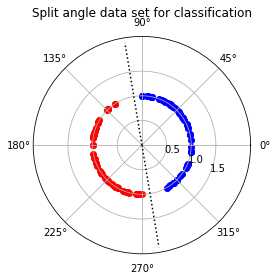

In [39]:
results = estimate_splitting_angle(.05, thetas.tolist(), labels.tolist(), 99)
plot_dataset(results["lower_boundary"], labels, thetas)

In [40]:
results

{'lower_boundary': 1.7357172166889296,
 'upper_boundary': 1.753877224350792,
 'lower_success_rate': 1.0,
 'upper_success_rate': 1.0,
 'threshold': 0.05,
 'delta': 0.036320015323724864}